In [1]:
import numpy as np
import ultraplot as uplt

In [143]:
NORM = 1.0 / np.sqrt(2.0 * np.pi)
INTK2 = 1.0 / 2.0 / np.sqrt(np.pi)

# snippet of code from k descent
# https://github.com/AlanPearl/diffopt/blob/main/diffopt/kdescent/kstats.py#L352C1-L366C26
#
# @partial(jax.jit, static_argnames=["return_err"])
# def _predict_kde_counts(x, x_weights, training_x, cov, kernel_inds,
#                         return_err=False):
#     kernel_probs = _get_kernel_probs(x, training_x, cov, kernel_inds)
#     kde_counts = _weighted_sum_over_samples(kernel_probs, x_weights)
#     if return_err:
#         x_weights_squared = None
#         if x_weights is not None:
#             x_weights_squared = x_weights ** 2
#         ess = kde_counts ** 2 / _weighted_sum_over_samples(
#             kernel_probs ** 2, x_weights_squared)
#         err = kde_counts / jnp.sqrt(ess)
#         return kde_counts, err
#     else:
#         return kde_counts

def _kernel_density(x, xk, h, wk=None):
    dx = x.reshape(-1, 1) - xk
    dx_h_2 = dx / h
    dx_h_2 = dx_h_2**2
    kvals = NORM / h * np.exp(-0.5 * dx_h_2)

    if wk is not None:
        px = np.mean(kvals * wk, axis=1).flatten()
    else:
        px = np.mean(kvals, axis=1).flatten()

    # correct result for variance in KDE from
    # https://faculty.washington.edu/yenchic/17Sp_403/Lec7-density.pdf
    # only formally correct for unweighted point sets
    px_err = INTK2 * px / h / xk.shape[0]

    # what kdescent does
    if wk is not None:
        kde_counts = np.sum(kvals * wk, axis=1).flatten()
        ess = kde_counts**2 / np.sum(kvals**2 * wk**2, axis=1).flatten()
        err = kde_counts / np.sqrt(ess)
    else:
        kde_counts = np.sum(kvals, axis=1).flatten()
        ess = kde_counts**2 / np.sum(kvals**2, axis=1).flatten()
        err = kde_counts / np.sqrt(ess)

    return px, np.sqrt(px_err), err / xk.shape[0]


def _make_plot(px, px_err, px_err_kdescent, xp, yp):
    fig, axs = uplt.subplots(figsize=(4, 4))

    axs.plot(xp,yp, color="black", label="true density")

    mn = np.mean(px, axis=0)
    sd = np.std(px, axis=0)
    sd_pred = np.nanmean(px_err, axis=0)
    sd_kdescent_pred = np.nanmean(px_err_kdescent, axis=0)

    # axs.plot(x, mn, "o")
    # axs.errorbar(x, mn, sd, fmt="o")
    axs.plot(x, mn, color="blue", label="KDE est.")
    axs.fill_between(
        x, mn - sd, mn + sd,
        color="blue", alpha=0.5, label="KDE std over realizations"
    )

    axs.plot(x, mn - sd_pred, color="purple", label="KDE est. of std.")
    axs.plot(x, mn + sd_pred, color="purple")
    # axs.fill_between(
    #     x, mn - sd_pred, mn + sd_pred,
    #     color="dark gray", alpha=0.25, label="KDE est. of std."
    # )

    axs.plot(
        x, mn - sd_kdescent_pred,
        color="red", linestyle="dashed"
    )
    axs.plot(
        x, mn + sd_kdescent_pred,
        color="red", linestyle="dashed", label="KDESCENT est. of std."
    )
    # axs.fill_between(
    #     x, mn - sd_kdescent_pred, mn + sd_kdescent_pred,
    #     color="red", alpha=0.25, label="KDESCENT est. of std."
    # )

    axs.format(yscale="log", ylim=(1e-2, 2))
    axs.legend(loc="ll", ncols=1, frameon=False)

    return fig, axs


(Figure(nrows=1, ncols=1, figwidth=np.float64(4.0), figheight=np.float64(4.0)),
 SubplotGrid(nrows=1, ncols=1, length=1))

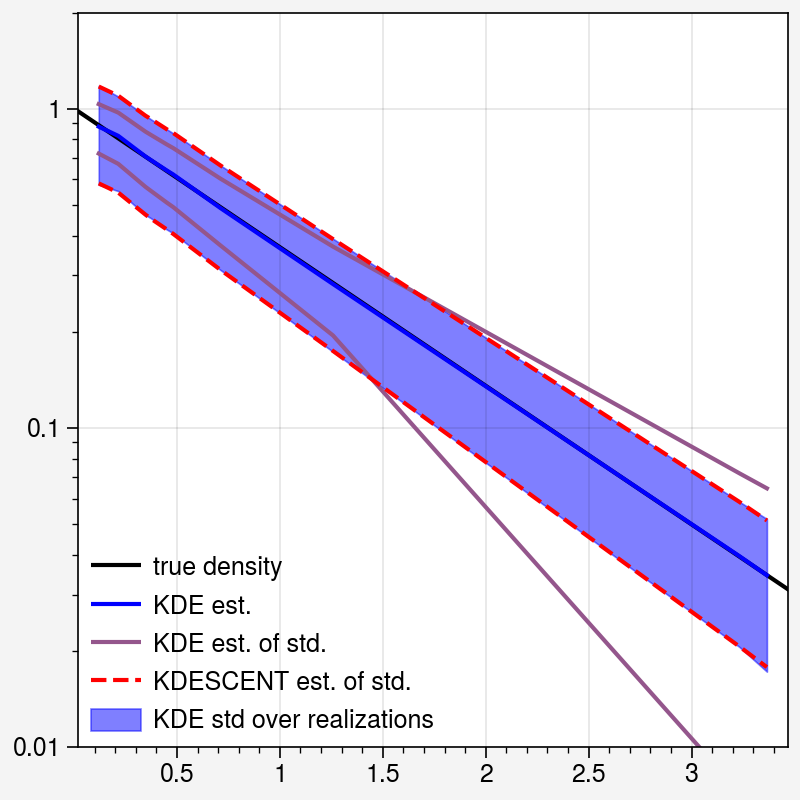

In [176]:
base_seed = 4
nk = 200
samp_scale = 4
h = 0.05

rng = np.random.default_rng(seed=base_seed)
seeds = rng.uniform(1, 1_000_000_000, size=1000).astype(int)
x = np.sort(rng.exponential(size=10))

px = []
px_err = []
px_err_kdescent = []
for seed in seeds:
    rng = np.random.default_rng(seed=seed)
    xk = rng.exponential(size=nk, scale=samp_scale)
    wk = np.exp(-xk) / (np.exp(-xk / samp_scale) / samp_scale)
    (
        _px,
        _px_err,
        _px_err_kdescent
    ) = _kernel_density(
        x, xk, h, wk=wk
    )
    px_err.append(_px_err)
    px_err_kdescent.append(_px_err_kdescent)
    px.append(_px)

px = np.array(px)
px_err = np.array(px_err)
px_err_kdescent = np.array(px_err_kdescent)


xp = np.linspace(max(x.min() - 0.1, 0.0), x.max() + 0.1, 1000)
yp = np.exp(-xp)

_make_plot(px, px_err, px_err_kdescent, xp, yp)


(Figure(nrows=1, ncols=1, figwidth=np.float64(4.0), figheight=np.float64(4.0)),
 SubplotGrid(nrows=1, ncols=1, length=1))

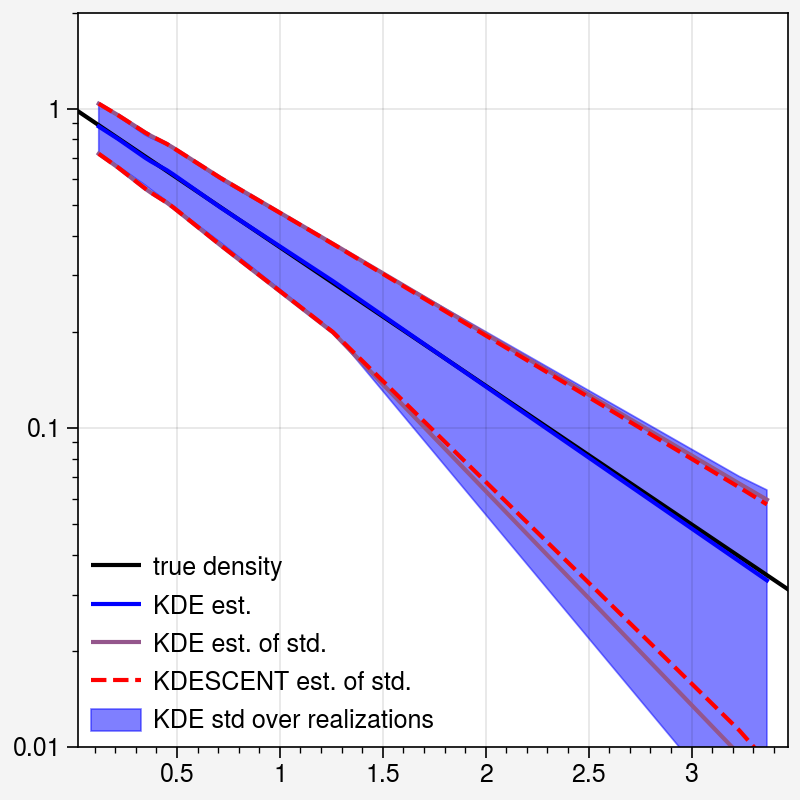

In [177]:
base_seed = 4
nk = 200
samp_scale = 1
h = 0.05

rng = np.random.default_rng(seed=base_seed)
seeds = rng.uniform(1, 1_000_000_000, size=1000).astype(int)
x = np.sort(rng.exponential(size=10))

px = []
px_err = []
px_err_kdescent = []
for seed in seeds:
    rng = np.random.default_rng(seed=seed)
    xk = rng.exponential(size=nk, scale=samp_scale)
    wk = np.exp(-xk) / (np.exp(-xk / samp_scale) / samp_scale)
    (
        _px,
        _px_err,
        _px_err_kdescent
    ) = _kernel_density(
        x, xk, h, wk=wk
    )
    px_err.append(_px_err)
    px_err_kdescent.append(_px_err_kdescent)
    px.append(_px)

px = np.array(px)
px_err = np.array(px_err)
px_err_kdescent = np.array(px_err_kdescent)


xp = np.linspace(max(x.min() - 0.1, 0.0), x.max() + 0.1, 1000)
yp = np.exp(-xp)

_make_plot(px, px_err, px_err_kdescent, xp, yp)
